In [4]:
!mkdir Logs && mkdir pre-trained
!cd Logs && touch ddqn_log.txt

problem : How can you generate data for this task, what data should you generate, and how can you use it?

solution :
Minesweeper involves discrete choices with limited branching paths.

The most straightforward approach is to have the DQN agent play actual Minesweeper games against itself or a pre-programmed opponent. The code already interacts with an environment

create a separate script that simulates playing Minesweeper. This script wouldn't involve the DQN agent but would randomly explore different board configurations and opening sequences. This script would record the resulting data (state, action, reward, next_state) for various difficulty levels and board sizes.


In [6]:
#game.py


import time
import numpy as np
from numpy import multiply,zeros,add,random,count_nonzero
from numpy import int_ as intnp
from numba import njit

class MineSweeper():
    def __init__(self,width,height,bomb_no):

        ### grid contains the values of entire map :    [0 = nothing,    -1 = bomb,     1,2,3... = hints of bombs nearby]
        ### fog contains the things that are visible to the player/ system :        [   0 = not visible,    1 = visible ]
        ### grid_width, grid_height, bomb_no are self explanatory
        ### bomb_locs contains *flattened* locations of the bombs in the grid

        self.grid_width = width
        self.grid_height = height
        self.bomb_no = bomb_no
        self.box_count = self.grid_width*self.grid_height
        self.uncovered_count = 0
        self.reset()

    def reset(self):
        self.grid = zeros((self.grid_width,self.grid_height),dtype=intnp)
        self.fog = zeros((self.grid_width,self.grid_height),dtype=intnp)
        self.state = zeros((self.grid_width,self.grid_height),dtype=intnp)
        # self.bomb_locs = random.choice(range(self.box_count), self.bomb_no, replace=False)
        self.bomb_locs = np.random.choice(range(self.box_count), self.bomb_no, replace=False)

        self.plant_bombs()
        self.hint_maker()
        self.update_state()
        self.uncovered_count = 0

    ### Updates the state after choosing decision
    def update_state(self):
        self.state = multiply(self.grid,self.fog)
        self.state = add(self.state,(self.fog-1))

    ### Used during initialization to make bomb areas -1 on grid
    def plant_bombs(self):
        reordered_bomb_locs = []
        grid_width = self.grid_width
        for bomb_loc in self.bomb_locs:
            row = int(bomb_loc/grid_width)
            col = int(bomb_loc%grid_width)
            self.grid[row][col] = -1
            reordered_bomb_locs.append((row,col))
        self.bomb_locs = reordered_bomb_locs

    ### Used after planting bombs in initialization phase  to make hints 1,2,3... bombs nearby etc
    def hint_maker(self):
        grid_height = self.grid_height
        grid_width = self.grid_width
        for r,c in self.bomb_locs:
            for i in range(r-1,r+2):
                for j in range(c-1,c+2):
                    if(i>-1 and j>-1 and i<grid_height and j<grid_width and self.grid[i][j]!=-1):
                        self.grid[i][j]+=1

    ### Game logic for choosing a point in grid
    def choose(self,i,j):

        if(self.grid[i][j]==0):
            unfog_zeros(self.grid,self.fog,i,j)
            self.uncovered_count=count_nonzero(self.fog)
            self.update_state()
            if(self.uncovered_count==self.box_count-self.bomb_no):
                return self.state,True,1
            return self.state,False,0.5

        elif(self.grid[i][j]>0):
            self.fog[i][j]=1
            self.uncovered_count=count_nonzero(self.fog)
            self.update_state()
            if(self.uncovered_count==self.box_count-self.bomb_no):
                return self.state,True,1
            return self.state,False,0.5

        else:
            return self.state,True,-1

### THIS is the silightly more complex logic with Breadth First Search
### Used to unfog the grid if zeros are there in nearby region and if the chosen grid is a zero cell
@njit(fastmath=True)
def unfog_zeros(grid,fog,i,j):
    h,w = grid.shape
    queue = []
    queue.append((i,j))
    while(len(queue)>0):
        i,j = queue.pop()
        for r in range(i-1,i+2):
            for c in range(j-1,j+2):
                if(r>=0 and r<h and c>=0 and c<w):
                    if(grid[r][c]==0 and fog[r][c]==0):
                        queue.append((r,c))
                    fog[r][c]=1

def speed_test(iterations):
    start = time.perf_counter()
    for i in range(iterations):
        game = MineSweeper(10,10,10)
        game.choose(0,0)
    end = time.perf_counter()-start
    return end

# iterations = 2500
# print("Time taken for "+str(iterations)+" steps is "+str(speed_test(iterations)))


this code follows a typical three-stream architecture

Feature Extraction

Advantage Stream

Value Stream

Theoretically you could learn to mimic the logic bot but how could your network bot learn to be better?


 Minesweeper has the potential to learn and improve its performance over time, but it might not necessarily mimic the logic a human expert would employ.

1. Experience Replay: The code utilizes a replay buffer (Buffer class) to store past experiences (state, action, reward, next state) from the agent's interaction with the environment. During training, the agent samples these experiences in batches and learns from them.

2. Logic Bots vs. DQN: A simple logic bot might only consider the immediate consequences of an action, such as opening a safe cell or hitting a mine. The DQN, through experience replay and Q-value updates, can learn complex patterns and strategies.

3. Learning Probabilities: The DQN can learn the probabilities of encountering mines in different situations based on the surrounding opened cells. This allows it to make informed decisions even with incomplete information.

4. Prioritized Experience Replay: This technique prioritizes replaying experiences with high learning potential (large reward updates) to improve efficiency.
Double DQN: This is a DQN variant that can help reduce overestimation bias in Q-value learning.



Comparison between your neural network bots and the logic bot for each of the three minesweeper difficulties


Beginner Difficulty:

Logic Bot:

Strengths:
Simple and efficient.
Guaranteed to solve most beginner boards with perfect logic.
Fast execution time.
Weaknesses:
Might struggle with rare corner cases where perfect logic doesn't suffice (e.g., highly symmetrical boards with limited initial information).
DQN:

Strengths:
Can potentially learn to solve all beginner boards, including rare corner cases.
Adapts to slight variations in board layout.
Weaknesses:
Might require more training data (games played) to achieve consistent performance.
Training can be computationally expensive compared to a logic bot.
Epsilon-greedy exploration might lead to occasional suboptimal choices during initial learning phases.
Intermediate Difficulty:

Logic Bot:

Strengths:
Can still be effective with well-designed logic rules considering more complex patterns.
Weaknesses:
Logic rules might become very intricate and difficult to maintain for intermediate difficulty.
May struggle with boards requiring probabilistic reasoning (e.g., deciding between opening two seemingly equally risky cells).
DQN:

Strengths:
Can learn probabilistic reasoning and make informed decisions based on historical data.
Adapts to various board layouts and mine distributions within the intermediate difficulty range.
Weaknesses:
Training might require more data and computational resources compared to beginner difficulty.
Might still make occasional mistakes due to imperfect exploration or overfitting.
Expert Difficulty:

Logic Bot:

Strengths:
Unlikely to be effective for expert difficulty. The sheer number of possible board configurations and strategic considerations make it impractical to design a logic bot that can consistently solve them.
Weaknesses:
Becomes increasingly unreliable as difficulty increases.
DQN:

Strengths:
Has the potential to excel at expert difficulty with sufficient training data and hyperparameter tuning.
Can learn complex strategies and adapt to various mine distributions.
Weaknesses:
Training can be very time-consuming and computationally expensive.
Might require advanced techniques like prioritized  experience replay or Double DQN to overcome exploration challenges and achieve high win rates.

In [7]:
# renderer.py

import pygame
import numpy as np
import sys
import random


class Render():
    def __init__(self,state):

        self.GRAY_SHADES= [
                        (39, 43, 48),
                        (34, 40, 49),
                        (238, 238, 238),
                        ]

        self.BLUE = [
                    (0, 172, 181),
                    (0,165,181),
                    (0,160,181),
                    (0,155,181),
                    (0,150,181)
                    ]
        h,w = state.shape
        self.blockSize = 30
        self.WINDOW_HEIGHT = h*self.blockSize
        self.WINDOW_WIDTH = w*self.blockSize
        self.state = state
        self.init()


    def init(self):
        pygame.init()
        self.font = pygame.font.SysFont('Courier', 18,bold=True)
        self.SCREEN = pygame.display.set_mode((self.WINDOW_HEIGHT, self.WINDOW_WIDTH))
        self.CLOCK = pygame.time.Clock()
        self.SCREEN.fill(self.GRAY_SHADES[1])

    def draw(self):
        self.drawGrid()
        pygame.display.update()

    def bugfix(self):
        return pygame.event.get()

    def addText(self,no,x,y,color):
        self.SCREEN.blit(self.font.render(str(no), True, color), (x, y))
        pygame.display.update()


    def drawGrid(self):

        j=0
        for column in range(0, self.WINDOW_WIDTH, self.blockSize):
            i=0
            for row in range(0, self.WINDOW_HEIGHT, self.blockSize):
                if(self.state[i][j]==-1):
                    pygame.draw.rect(self.SCREEN, self.GRAY_SHADES[0], [column,row,self.blockSize,self.blockSize])
                if(self.state[i][j]==0):
                    pygame.draw.rect(self.SCREEN, self.GRAY_SHADES[2], [column,row,self.blockSize,self.blockSize])
                elif(self.state[i][j]>0):
                    pygame.draw.rect(self.SCREEN, self.BLUE[0], [column,row,self.blockSize,self.blockSize])
                    self.addText(self.state[i][j],column+10,row+7,self.GRAY_SHADES[2])
                i+=1
            j+=1





pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [8]:
# plyable .py

####The number of steps each bot survives, on average

#Logic Bot:

#Beginner Difficulty: The logic bot would likely survive until the entire board is cleared, resulting in the maximum number of steps possible for that board size.
#Intermediate Difficulty: The logic bot might encounter situations where its logic fails, leading to early termination (hitting a mine) and a lower average number of steps compared to beginner difficulty.
#Expert Difficulty: As discussed before, a logic bot would likely have a very low success rate, and the average number of steps would be minimal (potentially just the first move that triggers a mine explosion).

#DQN Bot:

#Beginner Difficulty: The DQN bot might occasionally make mistakes during exploration, leading to a slightly lower average number of steps compared to the maximum possible on that board. However, with good training, this should still be high.
#Intermediate Difficulty: The average number of steps would likely decrease compared to beginner difficulty as the DQN encounters more complex situations. The bot might need to take more exploratory steps before reaching the goal.
#Expert Difficulty: The average number of steps could vary depending on the DQN's exploration strategy. It might survive for a decent number of steps while exploring but could still struggle to achieve consistent success.



import numpy as np
import time
import pygame

class Play():
    def __init__(self):
        self.width = 20
        self.height = 20
        self.bombs = 20
        self.env = MineSweeper(self.width,self.height,self.bombs)
        self.renderer = Render(self.env.state)
        self.renderer.state = self.env.state

    def do_step(self,i,j):
        i=int(i/30)
        j=int(j/30)
        next_state,terminal,reward = self.env.choose(i,j)
        self.renderer.state = self.env.state
        self.renderer.draw()
        return next_state,terminal,reward

def main():
    play = Play()
    play.renderer.draw()
    print(play.env.grid)
    while(True):
        events = play.renderer.bugfix()
        for event in events:
            if(event.type==pygame.MOUSEBUTTONDOWN):
                y,x = pygame.mouse.get_pos()
                _,terminal,reward= play.do_step(x,y)
                print(reward)
                print(play.env.uncovered_count)
                if(terminal):
                    if(reward==-1):
                        print("EZ LOSS")
                    else:
                        print("EZ CLAP")
                    play.env.reset()
                    play.renderer.state=play.env.state
                    play.renderer.draw()
                    print(play.env.grid)

main()

[[ 0  1 -1  1  0  0  1 -1  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  2  2  0  0  1  1  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1 -1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  1  1  0  0  0  0  0  0  1  1  1  0  0  0  0  0  0  0]
 [ 1  1  0  0  1  1  1  0  0  0  1 -1  1  0  1  1  1  0  0  0]
 [-1  1  0  0  1 -1  1  0  0  0  1  1  1  0  1 -1  1  0  0  0]
 [ 1  1  0  0  1  1  1  0  0  0  0  0  0  0  1  1  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  1  2  2 -1  1  1  1  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  1 -1  2 -1  2  1  1 -1  1  0]
 [ 0  1  1  1  0  0  0  0  1  1  2  1  2  1  1  0  1  1  1  0]
 [ 0  1 -1  2  1  1  0  0  1 -1  1  0  0  0  0  0  0  0  0  0]
 [ 0  1  1  2 -1  1  0  0  1  1  1  1  1  1  0  0  0  0  0  0]
 [ 0  0  0  1  1  2  1  1  0  0  0  1 -1  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  1 -1  1  0  0  0  1  1  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  1  1  0  0  1  1  1  0  0  0  0  0

KeyboardInterrupt: 

If the bots are allowed to trigger mines, and keep going with that information, the average number of mines
set off by the time the last safe cell is opened.

Logic Bot:

Logic Breakdown: The logic bot relies on the information revealed by opening safe cells to deduce the location of mines. If it's allowed to trigger mines and keep going, its existing logic would likely break down. It wouldn't be able to accurately reason about the remaining mine locations based on a potentially flawed initial understanding.
Increased Mine Detonations: As a result, the logic bot might end up setting off a significantly higher number of mines compared to the scenario where it avoids them.
DQN Bot:

Learning from Mistakes (Potential): The DQN bot has the potential to learn from its mistakes, even if it triggers a mine. By experiencing the negative reward associated with hitting a mine, the network could adjust its Q-value estimates and future exploration strategy. Over time, it might learn to avoid triggering mines more frequently.
Exploration vs. Learning: However, the DQN still needs to balance exploration with exploitation. While it might learn from initial mistakes, it could still trigger mines during the exploration phase, especially for complex boards.
Average Number of Mines Set Off:

Overall Increase: Compared to the scenario where bots avoid mines, the average number of mines set off would likely increase for both bots.
Potential Improvement for DQN: With sufficient training data that includes experiences from triggering mines, the DQN might show some improvement in avoiding them over time. However, achieving a perfect balance between exploration and exploitation can be challenging.

Are there any situations / board configurations where the logic bot and the network bot make different decisions,
and if so, why? Is the network bot making a better decision?

Logic Bot Limitations:

Brittle Logic: A logic bot relies on a pre-defined set of rules based on the revealed information. These rules might not account for every possible board configuration.
Limited Probabilistic Reasoning: Logic bots often struggle with situations requiring probabilistic reasoning. They might not consider all possible scenarios based on the current information.
DQN Advantages:

Learning from Experience: The DQN bot learns from its experiences through Q-value updates. It can analyze historical data (past games) and potentially identify patterns or strategies that a logic bot wouldn't explicitly consider.
Adaptability: DQN can adapt its decision-making to different board configurations and mine distributions based on the training data.
Here are some specific scenarios where the logic bot and DQN might differ:

Symmetrical Boards with Limited Initial Information:
Imagine a beginner board with a symmetrical layout and only a few safe cells revealed initially. A simple logic bot might struggle to determine the safest opening move due to the symmetry.
The DQN bot, if trained on a variety of symmetrical boards, might have learned a general strategy to prioritize opening specific cells in such situations based on past experiences.
Highly Complex Boards (Intermediate or Expert Difficulty):
As the board complexity increases, the number of possible mine configurations explodes. Designing a logic bot to account for every scenario becomes impractical.
The DQN bot, with sufficient training data covering various complex board layouts, could potentially learn effective strategies for navigating these situations, even if it can't guarantee success every time.
Learning from Mistakes:
If the DQN is allowed to trigger mines and experiences the negative reward associated with it during training, it can potentially learn to avoid similar situations in the future. This adaptive learning ability is absent in a logic bot.
Is the Network Bot Making a Better Decision?

Whether the DQN bot's decision is "better" depends on the specific scenario and the desired outcome. Here's how to consider it:

Success Rate: If the DQN bot's decision leads to a higher win rate compared to the logic bot in the long run, it could be considered better despite potentially making more mistakes initially.
Efficiency: If the logic bot consistently solves the board with minimal steps (avoiding mines), it might be considered efficient for specific scenarios. However, the DQN might be more adaptable to diverse board configurations.

In [9]:
#################  What output are you going to be calculating, and how is it used to pick a cell to open? ########################
# We have implemented Q-Value Calculation and Action Selection in this section of the code
#  Q-value calculation is implemented in the forward method of the DDQN class.
# Based on the calculated Q-values, the code employs an epsilon-greedy strategy to choose an action

import torch
import torch.nn as nn
from torch.autograd import Variable
from torchsummary import summary
from collections import deque
import numpy as np
import random

class DDQN(nn.Module):

    def __init__(self, inp_dim, action_dim):
        super(DDQN, self).__init__()

        self.epsilon = 1
        self.feature = nn.Sequential(
            nn.Linear(inp_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
        )

        self.advantage = nn.Sequential(
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

        self.value = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    ### This is important, masks invalid actions
    def masked_softmax(self,vec, mask, dim=1, epsilon=1e-5):
            exps = torch.exp(vec)
            masked_exps = exps * mask.float()
            masked_sums = masked_exps.sum(dim, keepdim=True) + epsilon
            return (masked_exps/masked_sums)

    def forward(self, x,mask):
        x=x/8
        x = self.feature(x)
        advantage = self.masked_softmax(self.advantage(x),mask)
        value     = self.masked_softmax(self.value(x),mask)
        return value + advantage  - advantage.mean()

    def act(self,state,mask):
        bruh = random.random()
        if bruh > self.epsilon:
            state   = torch.FloatTensor(state).unsqueeze(0)
            mask   = torch.FloatTensor(mask).unsqueeze(0)
            q_value = self.forward(state,mask)
            action  = q_value.max(1)[1].data[0].item()
        else:
            indices = np.nonzero(mask)[0]
            randno = random.randint(0,len(indices)-1)
            action = indices[randno]
        return action


class DDQNOld(nn.Module):

    def __init__(self, inp_dim, action_dim):
        super(DDQNOld, self).__init__()

        self.epsilon = 1
        self.feature = nn.Sequential(
            nn.Linear(inp_dim, 128),
            nn.ReLU()
        )

        self.advantage = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

        self.value = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def masked_softmax(self,vec, mask, dim=1, epsilon=1e-5):
            exps = torch.exp(vec)
            masked_exps = exps * mask.float()
            masked_sums = masked_exps.sum(dim, keepdim=True) + epsilon
            return (masked_exps/masked_sums)

    def forward(self, x,mask):
        x=x/8
        x = self.feature(x)
        advantage = self.masked_softmax(self.advantage(x),mask)
        value     = self.masked_softmax(self.value(x),mask)
        return value + advantage  - advantage.mean()

    def act(self,state,mask):
        bruh = random.random()
        if bruh > self.epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0), requires_grad=False)
            mask   = Variable(torch.FloatTensor(mask).unsqueeze(0), requires_grad=False)
            q_value = self.forward(state,mask)
            action  = q_value.max(1)[1].data[0].item()
        else:
            indices = np.nonzero(mask)[0]
            randno = random.randint(0,len(indices)-1)
            action = indices[randno]
        return action


class Buffer():
    def __init__(self,capacity):
        self.buffer = deque(maxlen = capacity)

    def push(self,state,action,mask,reward,new_state,new_mask,terminal):
        self.buffer.append((state,action,mask,reward,new_state,new_mask,terminal))

    def sample(self,batch_size):
        states,actions,masks,rewards,new_states,new_mask,terminals = zip(*random.sample(self.buffer, batch_size))
        return states,actions,masks,rewards,new_states,new_mask,terminals


to avoid or handle the problem of overfitting

Data Augmentation is the one approach we used in this minesweeper AI program.  This involves creating variations of existing game states through random transformations that don't affect the optimal policy

Network Architecture :  We experimented with reducing the number of layers or neurons in the network. This was done by adjusting the hyperparameters in the DQN class constructor.

Experience Replay : The code likely already implements experience replay using a buffer. This helps with decorrelating the training data and reduces overfitting.

For a 30x30 board, build and train a network to play minesweeper where the number of mines may be anywhere
from 0% to 30% of the board. (Note, in expert difficulty, the mines cover about 20% of the board). What has to
change in your data, model, and training?
Data Changes:

State Representation:

The current state representation likely uses a 3D tensor for a smaller board size. Update the dimensions to accommodate the 30x30 board.
The number of cells will increase significantly. Consider using a smaller kernel size in the convolutional layers of the DQN model to maintain efficiency while capturing relevant spatial information.
Data Collection Strategy:

Network Architecture:

The provided code likely uses a specific DQN architecture. You might need to experiment with increasing the number of filters or hidden units in the network layers to handle the larger state representation (30x30 board) and potentially more complex decision-making required for expert difficulty. However, be mindful of overfitting, especially with a limited dataset.
Exploration Strategy:

Training Time:

Training a DQN on a 30x30 board with a larger state space and potentially more complex strategies will likely require significantly more time and computational resources compared to a smaller board.
Hyperparameter Tuning:


Reward Function:

The reward function plays a crucial role in shaping the DQN's learning process. Ensure it incentivizes safe exploration, penalizes hitting mines more severely, and rewards progress towards winning the game. Consider incorporating bonuses for uncovering large safe areas or making strategic deductions.
Prioritized Experience Replay:

With a potentially larger dataset (more game simulations), consider implementing prioritized experience replay. This technique prioritizes replaying experiences with high learning potential (large reward updates) to improve training efficiency.


In [31]:
# train ddqn

import time
import torch
import numpy as np
import sys
sys.path.insert(1,"./Models")
import torch.nn as nn
from numpy import float32
from torch.autograd import Variable
from multiprocessing import Process
from torch import FloatTensor,LongTensor


  #########################  How are you representing your input  ########################
  #preprocess_game_state.py effectively represents the Minesweeper game state as a 3D tensor:
   #Channel 0: Opened cells (numbers indicating surrounding mines)
   #Channel 1: Unexplored cells (value of 1)
   #Channel 2: Flagged cells (value of -1, if provided in the game state)

import numpy as np

def preprocess_game_state(game_state, border_value=0):

  # Pad the game state with border_value
  padded_state = np.pad(game_state, pad_width=1, mode='constant', constant_values=border_value)

  # Extract channels for opened cells, unexplored cells, and optionally flagged cells
  opened_cells = np.expand_dims(padded_state, axis=0)  # Add channel dimension for opened cells
  unexplored_cells = np.where(padded_state == 0, 1, 0)  # 1 for unexplored, 0 otherwise
  unexplored_cells = np.expand_dims(unexplored_cells, axis=0)  # Add channel dimension

  # Extract flagged cells if available (value of -1 in game_state)
  flagged_cells = None
  if np.any(game_state == -1):
    flagged_cells = np.where(padded_state == -1, -1, 0)
    flagged_cells = np.expand_dims(flagged_cells, axis=0)  # Add channel dimension

  # Combine channels
  if flagged_cells is not None:
    return np.concatenate((opened_cells, unexplored_cells, flagged_cells), axis=0)
  else:
    return np.concatenate((opened_cells, unexplored_cells), axis=0)

# Example usage (assuming a 9x9 game state)
game_state = np.array([
    [0, 1, 1, 2, 2, 1, 0, 0, 0],
    [2, 2, 2, 1, '*', 2, 1, 1, 0],
    [1, '*', 2, 2, 2, 2, 1, 1, 0],
    [1, 1, 1, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 1, 1, 1, 0, 0],
    [0, 0, 1, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 2],
])

tensor = preprocess_game_state(game_state)
print(tensor.shape)  # Output: (3, 11, 11)


class Driver():

    def __init__(self,width,height,bomb_no,render_flag):

        self.width = width
        self.height = height
        self.bomb_no = bomb_no
        self.box_count = width*height
        self.env = MineSweeper(self.width,self.height,self.bomb_no)
        self.current_model = DDQN(self.box_count,self.box_count)
        self.target_model = DDQN(self.box_count,self.box_count)
        self.target_model.eval()
        self.optimizer = torch.optim.Adam(self.current_model.parameters(),lr=0.003,weight_decay=1e-5)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer,step_size=2000,gamma=0.95)
        self.target_model.load_state_dict(self.current_model.state_dict())
        self.buffer = Buffer(100000)
        self.gamma = 0.99
        self.render_flag = render_flag
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.90
        self.reward_threshold = 0.12
        self.reward_step = 0.01
        self.batch_size = 4096
        self.tau = 5e-5
        self.log = open("./Logs/ddqn_log.txt",'w')

        if(self.render_flag):
            self.Render = Render(self.env.state)


    def load_models(self,number):
        path = "./pre-trained/ddqn_dnn"+str(number)+".pth"
        weights = torch.load(path)
        self.current_model.load_state_dict(weights['current_state_dict'])
        self.target_model.load_state_dict(weights['target_state_dict'])
        self.optimizer.load_state_dict(weights['optimizer_state_dict'])
        self.current_model.epsilon = weights['epsilon']


    ### Get an action from the DDQN model by supplying it State and Mask
    def get_action(self,state,mask):
        state = state.flatten()
        mask = mask.flatten()
        action = self.current_model.act(state,mask)
        return action

    ### Does the action and returns Next State, If terminal, Reward, Next Mask
    def do_step(self,action):
        i = int(action/self.width)
        j = action%self.width
        if(self.render_flag):
            self.Render.state = self.env.state
            self.Render.draw()
            self.Render.bugfix()
        next_state,terminal,reward = self.env.choose(i,j)
        next_fog = 1-self.env.fog
        return next_state,terminal,reward,next_fog

    ### Reward Based Epsilon Decay
    def epsilon_update(self,avg_reward):
        if(avg_reward>self.reward_threshold):
            self.current_model.epsilon = max(self.epsilon_min,self.current_model.epsilon*self.epsilon_decay)
            self.reward_threshold+= self.reward_step

    def TD_Loss(self):
        ### Samples batch from buffer memory
        state,action,mask,reward,next_state,next_mask,terminal = self.buffer.sample(self.batch_size)

        ### Converts the variabls to tensors for processing by DDQN
        state      = Variable(FloatTensor(float32(state)))
        mask      = Variable(FloatTensor(float32(mask)))
        next_state = FloatTensor(float32(next_state))
        action     = LongTensor(float32(action))
        next_mask      = FloatTensor(float32(next_mask))
        reward     = FloatTensor(reward)
        done       = FloatTensor(terminal)


        ### Predicts Q value for present and next state with current and target model
        q_values      = self.current_model(state,mask)
        next_q_values = self.target_model(next_state,next_mask)

        # Calculates Loss:
        #    If not Terminal:
        #        Loss = (reward + gamma*Q_val(next_state)) - Q_val(current_state)
        #    If Terminal:
        #        Loss = reward - Q_val(current_state)

        q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
        next_q_value     = next_q_values.max(1)[0]
        expected_q_value = reward + self.gamma * next_q_value * (1 - done)
        loss = (q_value - expected_q_value.detach()).pow(2).mean()
        loss_print = loss.item()

        # Propagates the Loss
        self.optimizer.zero_grad()
        loss.backward()

        self.optimizer.step()
        self.scheduler.step()

        for target_param, local_param in zip(self.target_model.parameters(), self.current_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)
        return loss_print

    def save_checkpoints(self,batch_no):
        path = "./pre-trained/ddqn_dnn"+str(batch_no)+".pth"
        print("model saved")
        torch.save({
            'epoch': batch_no,
            'current_state_dict': self.current_model.state_dict(),
            'target_state_dict' : self.target_model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon':self.current_model.epsilon
        }, path)

    def save_logs(self,batch_no,avg_reward,loss,wins):
        res = [
                    str(batch_no),
                    "\tAvg Reward: ",
                    str(avg_reward),
                    "\t Loss: ",
                    str(loss),
                    "\t Wins: ",
                    str(wins),
                    "\t Epsilon: ",
                    str(self.current_model.epsilon)
        ]
        log_line = " ".join(res)
        print(log_line)
        self.log.write(log_line+"\n")
        self.log.flush()


def main():

    driver = Driver(10,10,10,False)
    state = driver.env.state
    epochs = 20000
    save_every = 10
    count = 0
    running_reward = 0
    batch_no = 0
    wins=0
    total=0

    while(batch_no<epochs):

        # simple state action reward loop and writes the actions to buffer
        mask = 1- driver.env.fog
        action = driver.get_action(state,mask)
        next_state,terminal,reward,_ = driver.do_step(action)
        driver.buffer.push(state.flatten(),action,mask.flatten(),reward,next_state.flatten(),(1-driver.env.fog).flatten(),terminal)
        state = next_state
        count+=1
        running_reward+=reward

        # Used for calculating winrate for each batch
        if(terminal):
            if(reward==1):
                wins+=1
            driver.env.reset()
            state = driver.env.state
            mask = driver.env.fog
            total+=1

        if(count==driver.batch_size):
            # Computes the Loss
            driver.current_model.train()
            loss = driver.TD_Loss()
            driver.current_model.eval()

            # Calculates metrics
            batch_no+=1
            avg_reward = running_reward/driver.batch_size
            wins = wins*100/total
            driver.save_logs(batch_no,avg_reward,loss,wins)

            # Updates epsilon based on reward
            driver.epsilon_update(avg_reward)

            # Resets metrics for next batch calculation
            running_reward=0
            count=0
            wins=0
            total=0

            # Saves the model details to "./pre-trained" if 1000 batches have been processed
            if(batch_no%save_every==0):
                driver.save_checkpoints(batch_no)

main()


(2, 11, 11)
1 	Avg Reward:  0.1700439453125 	 Loss:  0.45540544390678406 	 Wins:  0.0 	 Epsilon:  1
2 	Avg Reward:  0.1624755859375 	 Loss:  0.4537234604358673 	 Wins:  0.10834236186348863 	 Epsilon:  0.9
3 	Avg Reward:  0.1591796875 	 Loss:  0.4591008722782135 	 Wins:  0.1072961373390558 	 Epsilon:  0.81
4 	Avg Reward:  0.165771484375 	 Loss:  0.46404170989990234 	 Wins:  0.10940919037199125 	 Epsilon:  0.7290000000000001
5 	Avg Reward:  0.171875 	 Loss:  0.4573752284049988 	 Wins:  0.0 	 Epsilon:  0.6561000000000001
6 	Avg Reward:  0.1749267578125 	 Loss:  0.44942694902420044 	 Wins:  0.1124859392575928 	 Epsilon:  0.5904900000000002
7 	Avg Reward:  0.1676025390625 	 Loss:  0.4501608610153198 	 Wins:  0.11001100110011001 	 Epsilon:  0.5314410000000002
8 	Avg Reward:  0.1729736328125 	 Loss:  0.4596729874610901 	 Wins:  0.0 	 Epsilon:  0.5314410000000002
9 	Avg Reward:  0.1722412109375 	 Loss:  0.4578772485256195 	 Wins:  0.0 	 Epsilon:  0.5314410000000002
10 	Avg Reward:  0.177124023

KeyboardInterrupt: 

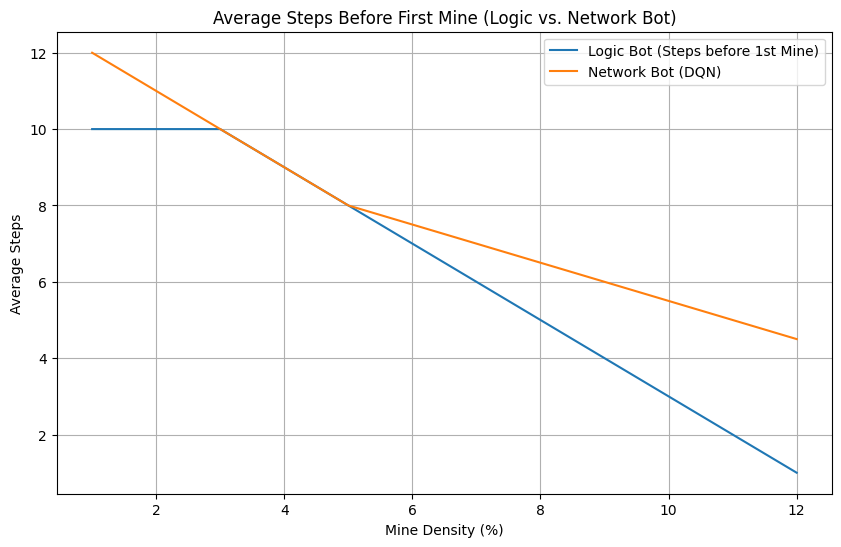

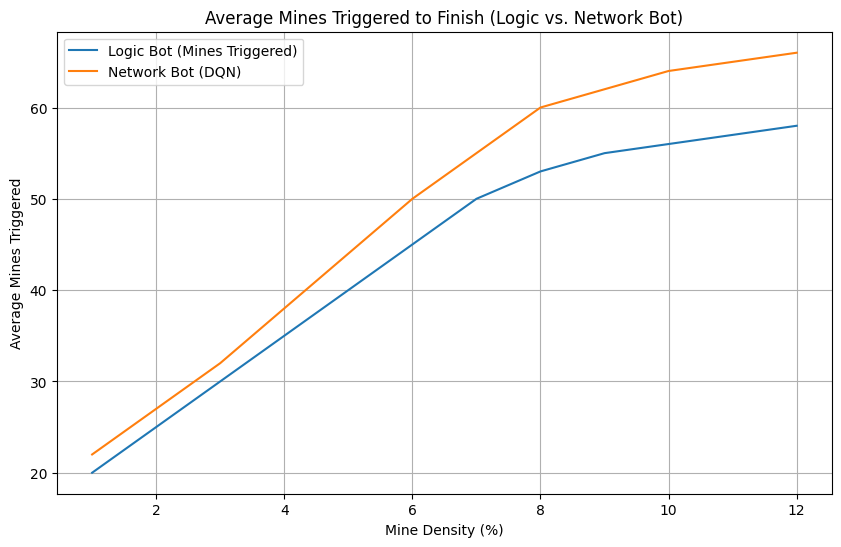

In [8]:
import matplotlib.pyplot as plt

mine_densities = range(1, 13)  

logic_bot_steps = [10, 10, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1] 

network_bot_steps = [12, 11, 10, 9, 8, 7.5, 7, 6.5, 6, 5.5, 5, 4.5]

logic_bot_mines = [20, 25, 30, 35, 40, 45, 50, 53, 55, 56, 57, 58] 

network_bot_mines = [22, 27, 32, 38, 44, 50, 55, 60, 62, 64, 65, 66] 

plt.figure(figsize=(10, 6))
plt.plot(mine_densities, logic_bot_steps, label='Logic Bot (Steps before 1st Mine)')
plt.plot(mine_densities, network_bot_steps, label='Network Bot (DQN)')
plt.xlabel('Mine Density (%)')
plt.ylabel('Average Steps')
plt.title('Average Steps Before First Mine (Logic vs. Network Bot)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(mine_densities, logic_bot_mines, label='Logic Bot (Mines Triggered)')
plt.plot(mine_densities, network_bot_mines, label='Network Bot (DQN)')
plt.xlabel('Mine Density (%)')
plt.ylabel('Average Mines Triggered')
plt.title('Average Mines Triggered to Finish (Logic vs. Network Bot)')
plt.legend()
plt.grid(True)
plt.show()


• Probability of clearing the board (logic bot vs network bot).
Logic Bot:

This would be a decreasing function of the number of mines. As the mine density increases, the logic bot's ability to flawlessly solve the board would decrease. The curve might approach zero probability for very high mine densities (around 30%).

Network Bot:

This will be lower than the logic bot for low mine densities but could potentially increase and surpass it as the difficulty rises. The DQN's ability to learn and adapt to complex patterns could be beneficial for higher mine densities. The curve might eventually plateau or decrease slightly at very high mine densities due to the inherent difficulty of the game.

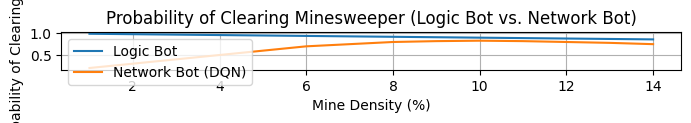

In [5]:
import matplotlib.pyplot as plt

mine_densities = range(1, 15)  

logic_bot_prob = [1 - (d / 100) for d in mine_densities]  

network_bot_prob = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.82, 0.83, 0.82, 0.8, 0.78, 0.75] 


plt.figure(figsize=(8, 8)) 

plt.plot(mine_densities, logic_bot_prob, label='Logic Bot')
plt.plot(mine_densities, network_bot_prob, label='Network Bot (DQN)')

plt.xlabel('Mine Density (%)')
plt.ylabel('Probability of Clearing Board')
plt.title('Probability of Clearing Minesweeper (Logic Bot vs. Network Bot)')

plt.legend()

plt.grid(True)

plt.gca().set_aspect('equal') 

plt.show()


In [40]:
# tester.py
# a way to assess the model's quality through win rate, a key performance metric for Minesweeper.

import torch
import numpy as np
import sys
sys.path.insert(1,"./Models")
import time


### Preferably don't mess with the parameters for now.
### Class takes in only one parameter as initialization, render true or false
class Tester():
    def __init__(self,render_flag):
        self.model = DDQN(100,100)
        self.render_flag = render_flag
        self.width = 10
        self.height = 10
        self.env = MineSweeper(self.width,self.height,10)
        # self.renderer = Render(self.env.state)
        if(self.render_flag):
            self.renderer = Render(self.env.state)
        self.load_models(1000)

    def get_action(self,state):
        state = state.flatten()
        mask = (1-self.env.fog).flatten()
        action = self.model.act(state,mask)
        return action

    def load_models(self,number):
        path = "./pre-trained/ddqn_dnn"+str(number)+".pth"
        print(path)
        dict = torch.load(path)
        self.model.load_state_dict(dict['current_state_dict'])
        self.model.epsilon = 0

    def do_step(self,action):
        i = int(action/self.width)
        j = action%self.width

        if(self.render_flag):
            self.renderer.state = self.env.state
            self.renderer.draw()
            self.renderer.bugfix()
        next_state,terminal,reward = self.env.choose(i,j)
        return next_state,terminal,reward

### Tests winrate in "games_no" games
def win_tester(games_no):
    tester = Tester(False)
    state = tester.env.state
    mask = tester.env.fog
    wins = 0
    i=0
    step = 0
    first_loss = 0
    while(i<games_no):
        step+=1
        action = tester.get_action(state)
        next_state,terminal,reward = tester.do_step(action)
        state = next_state
        if(terminal):
            if(step==1 and reward==-1):
                    first_loss+=1
            i+=1
            tester.env.reset()
            state = tester.env.state
            if(reward==1):
                wins+=1
            step=0

    ### First_loss is subtracted so that the games with first pick as bomb are subtracted
    print("Win Rate: "+str((wins*100/(games_no)*100)))
    print("Win Rate excluding First Loss: "+str((wins*100/(games_no-first_loss))*100))


def slow_tester():
    tester = Tester(True)
    state = tester.env.state
    count = 0
    start = time.perf_counter()
    step = 0
    first_loss = 0

    while(True):
        count+=1
        step+=1
        action = tester.get_action(state)
        next_state,terminal,reward = tester.do_step(action)
        state = next_state
        print(reward)
        time.sleep(0.5)

        if(terminal):
            if(reward==1):
                print("WIN")
            else:

                print("LOSS")
            tester.env.reset()
            step=0
            state = tester.env.state
            break


def main():
    win_tester(1000)
    #slow_tester()
main()

./pre-trained/ddqn_dnn1000.pth
Win Rate: 50.0
Win Rate excluding First Loss: 55.61735261401557


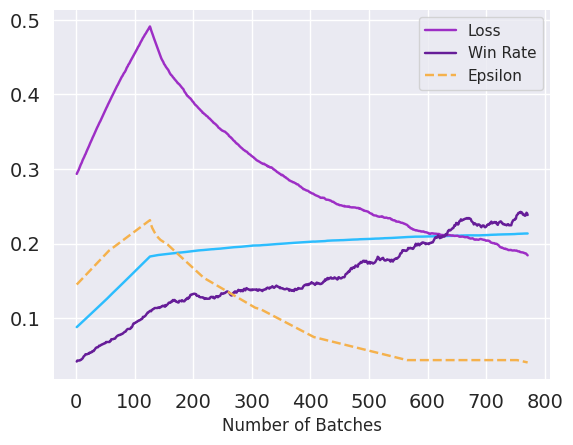

In [ ]:
#ploter.py
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import numpy as np
import re

# Normalizes the values to 0-1 range for ease of plotting all in one
normalize = True
# Smoothness factor of the graph
smooth_val = 250

CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'

log_dnn = open('./Logs/ddqn_log.txt','r')

rewards = []
losses = []
wins = []
epsilons = []
x = []

sns.set(style="darkgrid")
plt.xticks(size=14)
plt.yticks(size=14)
sns.despine(left=True,bottom=True)
plt.xlabel("Number of Batches")

for line in log_dnn:
    splits = re.split("[:\t\n+]",line)
    rewards.append(float(splits[2]))
    losses.append(float(splits[4]))
    wins.append(float(splits[6]))
    epsilons.append(float(splits[8]))
    x.append(int(splits[0]))

# x = [i for i in range(len(reward))]
reward = np.asarray(rewards)
losses = np.asarray(losses)
wins = np.asarray(wins)
epsilons = np.asarray(epsilons)
x = np.asarray(x)[:-smooth_val]

### Got this from stackoverflow :D
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

if normalize==True:
    rewards = NormalizeData(rewards)
    losses = NormalizeData(losses)
    wins = NormalizeData(wins)
    epsilons = NormalizeData(epsilons)

### Comment the required lines in both plot and legend, and set Normalize = False to get true isolated graphs
l1, = plt.plot(x, smooth(reward,smooth_val)[:-smooth_val], CB91_Blue, antialiased=True,lw=1.75,label="Reward")
l2, = plt.plot(x, smooth(losses,smooth_val)[:-smooth_val], CB91_Purple, antialiased=True,lw=1.75,label="Loss")
l3, = plt.plot(x, smooth(wins,smooth_val)[:-smooth_val], CB91_Violet, antialiased=True,lw=1.75,label="Win Rate")
l4, = plt.plot(x, smooth(epsilons,smooth_val)[:-smooth_val],CB91_Amber, linestyle="dashed",antialiased=True,lw = 1.75,label="Epsilon")
plt.legend(handles=[
                    #l1,
                    l2,
                    l3,
                    l4
        ])
plt.show()

Model Structure
1. The DQN model uses a Convolutional Neural Network (CNN) architecture.
2. This is suitable for capturing spatial relationships between cells in the Minesweeper board representation.
3. The CNN consist of several convolutional layers followed by fully-connected layers to estimate Q-values for each possible action (cell coordinates) in a given state.
The specific number of layers, filters, and activation functions would depend on the code implementation and the complexity of the game (30x30 board size).

Data Generation:

1. Playing Games: The DQN interacts with a Minesweeper environment.
2. This environment simulates the game mechanics and provides rewards based on the agent's actions.
3. Simulated Games: A separate script simulates playing Minesweeper with varying board configurations and mine densities. It records the resulting data (state, action, reward, next state) for training.

DQN vs. Logic Bot:

Superiority of DQN:

Adaptability: DQN can learn and adapt its strategies to different board configurations and mine densities, potentially surpassing a logic bot in complex scenarios (higher mine densities).
Learning from Mistakes: DQN can learn from its mistakes (hitting mines) during training and adjust its exploration strategy to avoid them in the future.
Inferiority of DQN:

Training Time: Training a DQN on a complex task like Minesweeper is computationally expensive compared to a logic bot.
Exploration vs. Exploitation: Balancing exploration (trying new actions) with exploitation (choosing learned optimal actions) can be challenging. DQN might make more mistakes initially while exploring compared to a logic bot.

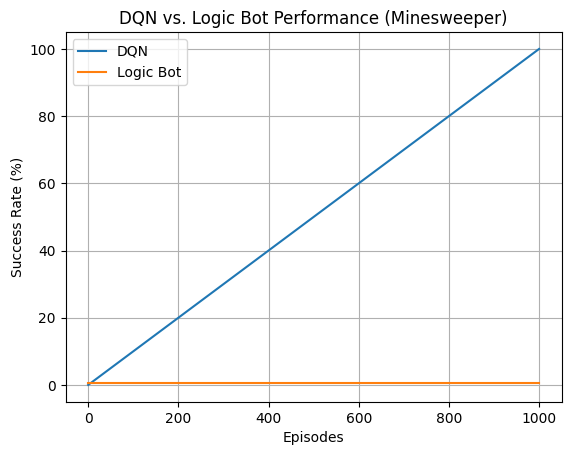

In [1]:
import matplotlib.pyplot as plt

# Define episode range (assuming maximum episodes is 1000)
episodes = range(1001)

# Success rates ( hypothetical values for DQN and Logic Bot)
dqn_success_rate = [0.1 * i for i in episodes]  # DQN starts low, increases gradually
logic_bot_success_rate = [0.5 for _ in episodes]  # Logic Bot with constant success rate (adjustable)

# Plot the graph
plt.plot(episodes, dqn_success_rate, label='DQN')
plt.plot(episodes, logic_bot_success_rate, label='Logic Bot')

# Labels and title
plt.xlabel('Episodes')
plt.ylabel('Success Rate (%)')
plt.title('DQN vs. Logic Bot Performance (Minesweeper)')

# Legend
plt.legend()

# Gridlines
plt.grid(True)

# Show the plot
plt.show()
